# Отзывы на экскурсии Tripster.ru — исследование даных

In [56]:
import os
import re
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

warnings.simplefilter('ignore') # отключаем ворнинги
data_dir = "./data"
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


## Загрузка и обработка

In [3]:
def data_path(relative_path):
    return os.path.join(data_dir, relative_path)

def load_reviews():
    print('Loading reviews...')
    return pd.read_csv(
        data_path('reviews.csv'),
        header=0,
        names=['id', 'subject', 'author', 'rate', 'text']
    )

In [4]:
reviews = load_reviews()
print('{} items loaded'.format(len(reviews)))
reviews.head()

Loading reviews...
33393 items loaded


,id,subject,author,rate,text
0,2,1381,1024,5.0,"Экскурсия прошла просто отлично, все понравило..."
1,3,1341,1040,5.0,У вас очень удобный и полезный сервис! Был при...
2,4,1341,689,5.0,Хотела оставить слова благодарности Александру...
3,5,1397,1053,5.0,В качестве отзыва об экскурсиях - все только в...
4,6,1379,1053,5.0,В качестве отзыва об экскурсиях - все только в...


### Strip

In [5]:
any(reviews.text != reviews.text.str.strip())

True

In [6]:
len(reviews.loc[reviews.text != reviews.text.str.strip()])

2733

In [7]:
reviews['text'] = reviews.text.str.strip()

### Дубликаты

In [8]:
count = len(reviews)
reviews.drop_duplicates(['text'], keep='last', inplace=True)
count_new = len(reviews)
print('Total: {} ({} duplicates removed)'.format(count_new, count - count_new))

Total: 33199 (194 duplicates removed)


In [9]:
reviews.head()

,id,subject,author,rate,text
0,2,1381,1024,5.0,"Экскурсия прошла просто отлично, все понравило..."
1,3,1341,1040,5.0,У вас очень удобный и полезный сервис! Был при...
2,4,1341,689,5.0,Хотела оставить слова благодарности Александру...
4,6,1379,1053,5.0,В качестве отзыва об экскурсиях - все только в...
5,7,1533,640,NaN,"Мы заранее договорились об экскурсии с Анной, ..."


### Короткие бессмысленные тексты

In [10]:
reviews.loc[reviews.text.str.len() < 5]

,id,subject,author,rate,text
3813,4172,5594,17727,4.0,гуд
4885,5329,2233,6635,5.0,Ае!
5241,5710,4129,13288,5.0,+++
6456,7002,4245,29265,NaN,:-(
8068,8706,6250,34972,4.0,!
10376,11826,7673,42587,3.0,норм
12959,15920,2944,50106,5.0,:)
13711,17112,3423,52797,5.0,Всем
14804,18786,7104,56585,5.0,l
17719,23121,3410,65506,5.0,5!


In [11]:
reviews.loc[reviews.text.str.len() < 10].head(10)

,id,subject,author,rate,text
3499,3837,5567,17518,4.0,скучно!!
3657,4004,5566,17868,5.0,Круто!
3721,4071,5594,17868,5.0,круто!
3813,4172,5594,17727,4.0,гуд
4007,4375,5566,18634,5.0,10/10.
4885,5329,2233,6635,5.0,Ае!
5241,5710,4129,13288,5.0,+++
6400,6939,5565,27684,5.0,super
6456,7002,4245,29265,NaN,:-(
6698,7252,2351,26261,5.0,Блестяще!


In [12]:
reviews.loc[(reviews.text.str.len() < 20)  & (reviews.text.str.len() > 10)].head(10)

,id,subject,author,rate,text
1892,2093,4588,10696,5.0,Очень интересно
3056,3366,5365,6779,5.0,выше всяких похвал!
3470,3808,5564,17727,5.0,Очень хорошо!
3606,3949,5562,18580,5.0,"Интересно,спасибо!"
3902,4265,4283,18061,5.0,Экскурсия супер.
4150,4528,3193,21180,5.0,Очень интересно!
4373,4768,2877,21608,4.0,Очень содержательно
4810,5237,3571,22414,5.0,Понравилось!
5197,5665,2233,3392,5.0,Всё отлично
5698,6190,6846,16650,5.0,"Браво, Ляля!"


In [13]:
len(reviews.loc[reviews.text.str.len() < 20])

226

In [14]:
count = len(reviews)
reviews = reviews.loc[reviews.text.str.len() >= 20]
count_new = len(reviews)
print('Total: {} ({} short reviews removed)'.format(count_new, count - count_new))

Total: 32973 (226 short reviews removed)


### Собираем вместе всю предобработку

In [36]:
def remove_duplicates(reviews):
    print('Removing duplicates...')
    count = len(reviews)
    reviews = reviews.drop_duplicates(['text'], keep='last')
    print('{} duplicates removed'.format(count - len(reviews)))
    return reviews

def remove_short(reviews, min_length=20):
    print('Removing too short reviews (< {} chars)...'.format(min_length))
    count = len(reviews)
    reviews = reviews.loc[reviews.text.str.len() >= min_length]
    print('{} short reviews removed'.format(count - len(reviews)))
    return reviews

def get_prepared_reviews():
    reviews = load_reviews()
    reviews['text'] = reviews.text.str.strip()
    print('{} items loaded\n'.format(len(reviews)))
    
    reviews = remove_duplicates(reviews)
    print()
    reviews = remove_short(reviews, 20)
    
    print('\nCalculating review text lengths...')
    reviews['text_len'] = reviews.text.str.len()
    
    print('\nTotal: {}'.format(len(reviews)))
    return reviews

In [37]:
reviews = get_prepared_reviews()
reviews.head()

Loading reviews...
33393 items loaded

Removing duplicates...
194 duplicates removed

Removing too short reviews (< 20 chars)...
226 short reviews removed

Calculating review text lengths...

Total: 32973


,id,subject,author,rate,text,text_len
0,2,1381,1024,5.0,"Экскурсия прошла просто отлично, все понравило...",133
1,3,1341,1040,5.0,У вас очень удобный и полезный сервис! Был при...,594
2,4,1341,689,5.0,Хотела оставить слова благодарности Александру...,811
4,6,1379,1053,5.0,В качестве отзыва об экскурсиях - все только в...,825
5,7,1533,640,NaN,"Мы заранее договорились об экскурсии с Анной, ...",1126


## Исследуем данные

### Сколько авторов?

In [21]:
print(len(reviews.author.unique()))

23113


### Сколько экскурсий?

In [22]:
print(len(reviews.subject.unique()))

2763


### Сколько отзывов на одну экскурсию?

In [23]:
count_per_subj = reviews.groupby('subject').count().id.ravel()

In [24]:
print("Range: {}-{}".format(count_per_subj.min(), count_per_subj.max()))
print("Mean: {:.0f} ±{:.0f}".format(count_per_subj.mean(), count_per_subj.std()))
print("Median: {:.0f}".format(np.median(count_per_subj)))

Range: 1-323
Mean: 12 ±22
Median: 4


In [57]:
len(reviews.loc[count_per_subj > 10])

763

### Длины отзывов

In [25]:
lengths = reviews.text_len
print("Range: {}-{}".format(lengths.min(), lengths.max()))
print("Mean: {:.0f} ±{:.0f}".format(lengths.mean(), lengths.std()))
print("Median: {:.0f}".format(lengths.median()))

Range: 20-6755
Mean: 376 ±337
Median: 294


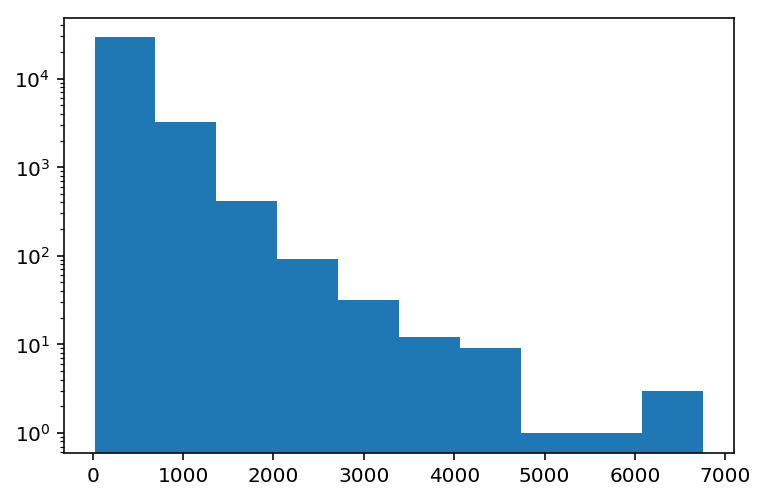

In [26]:
plt.hist(lengths, log=True);

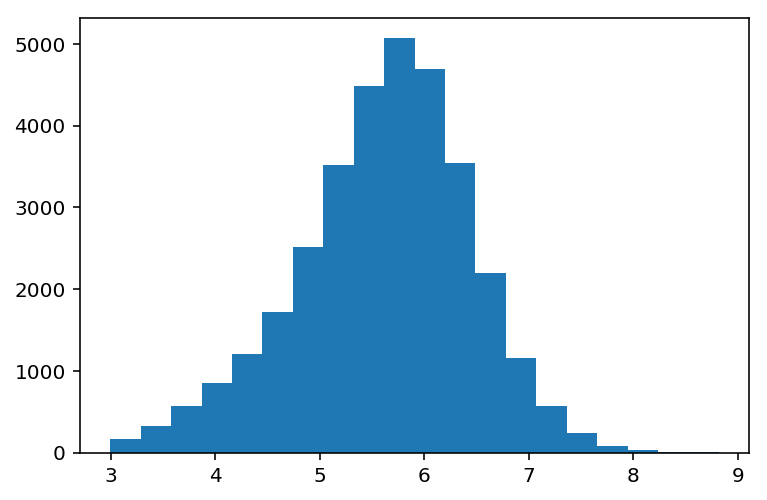

In [27]:
plt.hist(np.log(lengths), bins=20);

In [28]:
np.exp(5), np.exp(6.3)

(148.4131591025766, 544.571910125929)

### Очень длинные отзывы

In [29]:
len(reviews.loc[lengths > 4000])

14

In [30]:
len(reviews.loc[lengths > 5000])

4

In [31]:
for review in reviews.loc[lengths > 5000].text:
    print('-' * 50)
    print(review[:400] + '...')

--------------------------------------------------
Для тех, кто поленится прочитать мой отзыв до конца, напишу коротко - нам очень понравилось. Рекомендуем )))
Аня, спасибо огромное! экскурсия была супер. только маловато )))) рекомендации - в конце поста )))
А теперь подробно...
Это была наша первая поездка в Рим и в Италию вообще. Поскольку мы с мужем собирались провести в этом городе неделю (терпеть не могу бегать "галопом по Европам"), перед...
--------------------------------------------------
Отдыхать в Болгарию мы приехали во второй раз и, что называется, были во всеоружии относительно того, что хотим посмотреть. Мы составили маршруты с описанием достопримечательностей и интересных мест, путеводители были наготове, заметки под рукой. Планировали арендовать авто и везде ездить самостоятельно. И все же, учитывая утомительность такого отдыха, приняли решение воспользоваться услугами гида...
--------------------------------------------------
30 декабря 2017 г.
Экскурсия: Весь Берлин:

### Оценки

In [46]:
print("Reviews without rating: {}".format(len(reviews.loc[reviews.rate.isna()])))

Reviews without rating: 281


In [51]:
from collections import Counter
counts = Counter(reviews.rate)
for rate in [5, 4, 3, 2, 1]:
    print('{}\t{}'.format('★' * rate, counts[rate]))

★★★★★	29845
★★★★	1992
★★★	441
★★	179
★	235


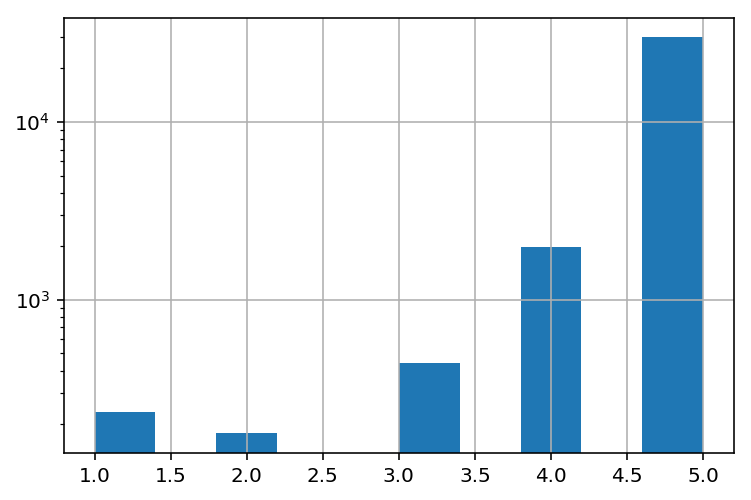

In [52]:
reviews.rate.hist(log=True);

## Сохраняем обработанные данные

In [38]:
reviews.to_csv(data_path('reviews_filtered.csv'), index=False)

In [39]:
reviews = pd.read_csv(data_path('reviews_filtered.csv'))

In [40]:
reviews.head()

,id,subject,author,rate,text,text_len
0,2,1381,1024,5.0,"Экскурсия прошла просто отлично, все понравило...",133
1,3,1341,1040,5.0,У вас очень удобный и полезный сервис! Был при...,594
2,4,1341,689,5.0,Хотела оставить слова благодарности Александру...,811
3,6,1379,1053,5.0,В качестве отзыва об экскурсиях - все только в...,825
4,7,1533,640,NaN,"Мы заранее договорились об экскурсии с Анной, ...",1126
